In [37]:
import networkx as nx
import numpy as np
from numpy.random import choice, rand 
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix, find
from IPython.core.display import display, HTML
np.random.seed(42)

In [38]:
def infection(m,beta):
    infection_probability = 1 - (1-beta)**m
    return 1 if np.random.rand(1)[0] <= infection_probability else 0

def recovery(p):
    return 1 if np.random.rand(1)[0] >= p else 0

def init_stats(duration,state):
    st = np.zeros([duration,state.shape[0]])
    stats = lil_matrix(st,shape=(duration,state.shape[0]),dtype=int) #faster sparse matrix creation/population
    stats[0,:] = state
    return stats

def group_sum(stats,row): #given the stathistics matrix it group elements with the same value and count value occurency
    previous_state = np.array(find(stats.getrow(row)))[1:]
    zeros = stats.shape[1]-previous_state.shape[1]
    count = {0:zeros}
    for idx in range(previous_state.shape[1]):
        node = previous_state[0,idx]
        value = previous_state[1,idx]
        count[value] = count.get(value,0) + 1
    return count
    
    
def count_new_state_increment(stats,moment, key=1): #performs the difference between two time periods (considering only the new cases)
    split = stats[moment-1:moment+1,:]
    cii = 0
    for n in range(split.shape[1]):
        if split[1,n] == key and split[0,n] != key: #check if the previous was not already in that state 
            cii += 1
    return cii
            


def epidemic_simulation(G,model,state,duration,beta,p,vaccination=None):
    stats = init_stats(duration,state)
    if vaccination:
        vaccinated = np.array([])
    for moment in range(1,duration): #for the duration of the study case
        if vaccination:
            #choose a percentual of vaccines (accordingly to the array given)
            vaccines = int((vaccination[moment]-vaccination[moment-1])/100 *state.shape[0]) 
            #choose randomly subjects of vaccination
            to_be_vaccinated = choice([x for x in range(state.shape[0]) if x not in vaccinated], vaccines, replace=False) 
            for vac in to_be_vaccinated:
                stats[moment:,vac] = 3 #sets the vaccined state
            vaccinated = np.concatenate([vaccinated,to_be_vaccinated])
        for node in G.nodes:
            if stats[moment,node] == 3: #vaccinated (skip)
                continue
            node_state = stats[moment-1,node]
            if node_state == 0: #susceptible
                neighbors = [n for n in G.neighbors(node)]
                infected_neighbors = [stats[moment-1,x] for x in neighbors].count(1) #counts the infected neighbors
                stats[moment,node] = infection(infected_neighbors,beta) #check if the subject gets infected
            elif node_state == 1: #infected
                recovered = recovery(p)
                stats[moment,node] = node_state + recovery(p)
                if recovered > 0: #recovered
                    stats[moment:,node] = 2
            else:
                continue
                
    stats = csr_matrix(stats) #faster sparse matrix computation
    return stats

def multiple_simulation(G,model,state,duration,beta,p,num,vaccination=None, plot=True):
    stats = epidemic_simulation(G,model,state,duration,beta,p,vaccination) #initial simulation
    for i in range(1,num):
        stats = np.column_stack((stats,epidemic_simulation(G,model,state,duration,beta,p,vaccination))) # num - 1 simulations
    ev_rate = compute_evolution(stats,duration,vaccination) #get the stats matrix and compute the evolution of cases
    if plot:
        duration = range(duration)
        return plot_avg_state(ev_rate,duration,vaccination)
    else: 
        return ev_rate

def compute_evolution(stats,duration,vaccination=None):
    initial_step = group_sum(stats[0,0],0) #start (t_0)
    initial_state = np.zeros(4 + (2 if vaccination else 0)) #initial state in t_0
    for k,v in initial_step.items():
        initial_state[k] = v
    initial_state[-1] = initial_step[1] 
    # initial state = [susceptible,infected,recovered,newly_infected] or if vaccination given
    # initial state = [susceptible,infected,recovered,newly_vaccinated,newly_infected]
    evolution_rate = initial_state
    for moment in range(1,duration):
        if vaccination:
            avg_state = np.zeros(6)
        else:
            avg_state = np.zeros(4)
        for simulation in range(0,stats.shape[1]):
            count = group_sum(stats[0,simulation],moment)
            for k,v in count.items():
                avg_state[k] += v
            avg_state[-1] += count_new_state_increment(stats[0,simulation],moment)
            if vaccination:
                avg_state[-2] += count_new_state_increment(stats[0,simulation],moment,key=3)
        avg_state = avg_state / stats.shape[1]
        evolution_rate = np.column_stack((evolution_rate, avg_state))
    return evolution_rate
        
        
def plot_avg_state(evolution_rate,duration,vaccination=None):
    #evolution_rate = compute_evolution(stats,duration,vaccination)
    ig, ax= plt.subplots(figsize=(10,7))
    ax.plot(duration, evolution_rate[0,:], label='S')
    ax.plot(duration, evolution_rate[1,:], label='I')
    ax.plot(duration, evolution_rate[2,:], label='R')
    if vaccination:
        ax.plot(duration, evolution_rate[3,:], label='Vaccinated')
        ax.plot(duration, evolution_rate[-2,:], label='New Vaccines')
    ax.plot(duration, evolution_rate[-1,:], label='New Infections')
    ax.set(xlabel='time (weeks)',ylabel='folks', title='Epidemic simulation')
    ax.legend(loc='best');
    return evolution_rate
    #print(evolution_rate)


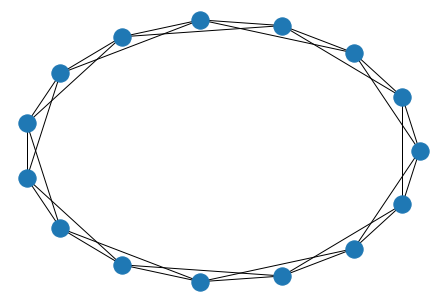

In [39]:
N = 15
nodes = range(N)
edges = []
for index,node in enumerate(nodes):
    edges.append([node,nodes[index-1]])
    edges.append([node,nodes[index-2]])
    
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw_circular(G)

In [3]:
# Init
N = 500
nodes = range(N)
edges = []
for index,node in enumerate(nodes):
    edges.append([node,nodes[index-1]])
    edges.append([node,nodes[index-2]])
    
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
#nx.draw_circular(G)
status = np.zeros(N)
beta = 0.3
p = 0.7
simulation_time = 15 #weeks
attempts = 100
SIR = {'S':0,'I':1,'R':2}

init_infected = choice(nodes,10)
for inf in init_infected:
    status[inf] = 1
print(init_infected)

[102 435 348 270 106  71 188  20 102 121]


array([[491.  , 480.33, 471.46, 465.21, 460.04, 456.2 , 452.76, 450.37,
        447.5 , 445.74, 444.37, 443.42, 442.47, 441.91, 441.18],
       [  9.  ,  15.09,  18.35,  18.48,  18.1 ,  16.84,  15.12,  13.7 ,
         12.24,  10.63,   9.  ,   7.41,   6.38,   5.38,   4.64],
       [  0.  ,   4.58,  10.19,  16.31,  21.86,  26.96,  32.12,  35.93,
         40.26,  43.63,  46.63,  49.17,  51.15,  52.71,  54.18],
       [  9.  ,  10.67,  10.7 ,   9.35,   8.87,   7.56,   7.13,   6.06,
          5.77,   4.67,   3.88,   3.17,   2.87,   2.28,   1.9 ]])

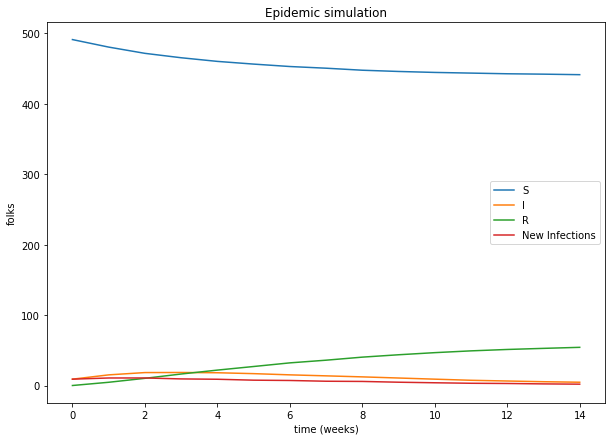

In [4]:
multiple_simulation(G,SIR,status,simulation_time,beta,p,attempts)

In [35]:
# Init
N = 500
nodes = range(N)
edges = []
for index,node in enumerate(nodes):
    edges.append([node,nodes[index-1]])
    edges.append([node,nodes[index-2]])
    
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
#nx.draw_circular(G)
status = np.zeros(N)
beta = 0.9
p = 0.6
simulation_time = 15 #weeks
attempts = 10
SIR = {'S':0,'I':1,'R':2}

init_infected = choice(nodes,10)
for inf in init_infected:
    status[inf] = 1
print(init_infected)

[423  19 433 246 284 130 138 255 449 167]


array([[490. , 454.6, 419. , 396.2, 374.6, 357.1, 341.1, 323.2, 308.9,
        296.1, 284.9, 271.6, 259.2, 247.3, 235.8],
       [ 10. ,  39.3,  53.1,  50.2,  50.6,  47.4,  46.2,  46.7,  41.1,
         36.7,  35.5,  34.7,  32.7,  31.1,  31. ],
       [  0. ,   6.1,  27.9,  53.6,  74.8,  95.5, 112.7, 130.1, 150. ,
        167.2, 179.6, 193.7, 208.1, 221.6, 233.2],
       [ 10. ,  35.4,  38.2,  31.7,  32.9,  29.4,  29.7,  29.8,  25.3,
         22.8,  21.2,  21.8,  20.5,  19.5,  19.2]])

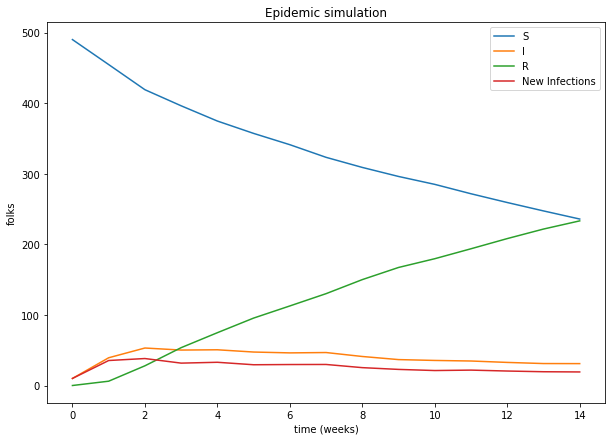

In [36]:
multiple_simulation(G,SIR,status,simulation_time,beta,p,attempts)

In [7]:
class RandomGraphGenerator():
    def __init__(self,n,k):
        self.G = nx.complete_graph(k+1)
        self.avg_degree = np.floor(k/2)
        self.need_balance = False if k % 2 == 0 else True
        for node in range(len(self.G),n):
            self.preferential_attachment()
            
    def addNode(self):
        node = len(self.G.nodes)
        self.G.add_node(node)
        grade=self.avg_degree
        if self.need_balance:
            grade += len(self.G) % 2
        return node,grade
        
    def preferential_attachment(self):
        node,grade = self.addNode()
        degrees = np.array([self.G.degree(x) for x in self.G.nodes])
        attachment_probabilities =  degrees /  np.sum(degrees)
        neighbors = np.random.choice(self.G.nodes, size=int(grade), replace=False, p = attachment_probabilities)
        for n in neighbors:
            self.G.add_edge(node,n)
        return
    
    def print(self,*param):
        print(param)

5.066666666666666


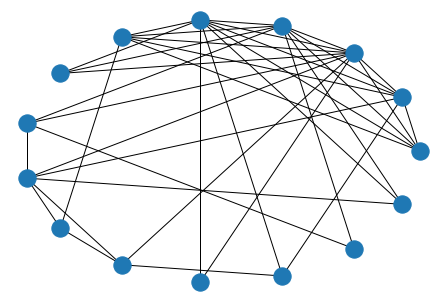

In [8]:
rg = RandomGraphGenerator(15,5)
print(np.mean(np.array([rg.G.degree(x) for x in rg.G.nodes])))
nx.draw_circular(rg.G)

[ 18  21 295 132 221 216 320 211 467 140]


array([[490.  , 471.58, 409.47, 294.44, 195.86, 151.8 , 139.9 , 137.18,
        135.35, 135.35, 135.26, 136.22, 136.45, 136.53, 137.32],
       [ 10.  ,  23.3 ,  75.79, 157.08, 191.49, 171.24, 135.37, 105.79,
         81.34,  62.58,  47.24,  35.75,  27.01,  20.42,  14.71],
       [  0.  ,   5.12,  14.74,  48.48, 112.65, 176.96, 224.73, 257.03,
        283.31, 302.07, 317.5 , 328.03, 336.54, 343.05, 347.97],
       [ 10.  ,  18.42,  64.3 , 119.76, 114.23,  77.47,  51.97,  38.96,
         30.23,  22.54,  16.74,  12.56,   9.59,   7.63,   4.93]])

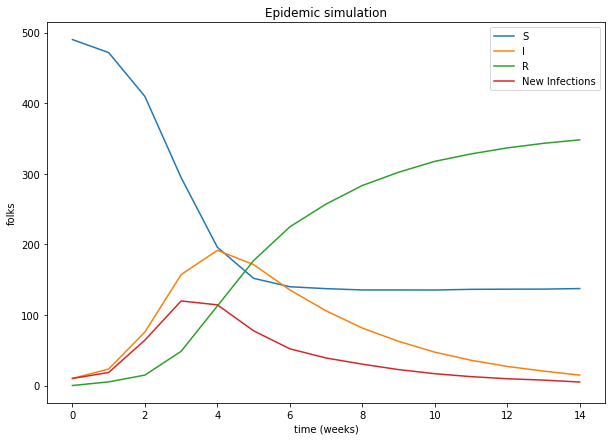

In [9]:
N = 500
k = 6
rg = RandomGraphGenerator(N,k)
status = np.zeros(N)
beta = 0.3
p = 0.7
simulation_time = 15 #weeks
attempts = 100
SIR = {'S':0,'I':1,'R':2}

init_infected = choice(rg.G.nodes,10, replace=False)
for inf in init_infected:
    status[inf] = 1
print(init_infected)
multiple_simulation(rg.G,SIR,status,simulation_time,beta,p,attempts)

[378 497 401 365 345  69 214 235 191  84]


array([[490.  , 454.46, 360.39, 247.07, 164.32, 120.77,  95.87,  87.03,
         89.29,  91.59,  93.2 ,  94.81,  95.49,  95.97,  96.62],
       [ 10.  ,  15.78,  54.77,  97.03, 100.73,  74.9 ,  47.96,  30.88,
         21.  ,  14.59,   9.61,   6.2 ,   4.36,   2.87,   1.85],
       [  0.  ,   4.76,   9.84,  30.9 ,  59.95,  79.33,  81.17,  82.09,
         89.71,  93.82,  97.19,  98.99, 100.15, 101.16, 101.53],
       [  0.  ,  25.  ,  75.  , 125.  , 175.  , 225.  , 275.  , 300.  ,
        300.  , 300.  , 300.  , 300.  , 300.  , 300.  , 300.  ],
       [  0.  ,  25.  ,  50.  ,  50.  ,  50.  ,  50.  ,  50.  ,  25.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [ 10.  ,  11.13,  47.77,  73.51,  58.92,  33.08,  17.82,   9.52,
          6.08,   4.24,   2.51,   1.64,   1.33,   0.96,   0.5 ]])

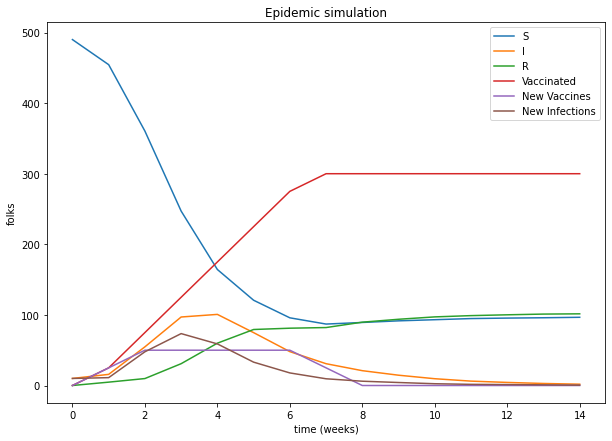

In [10]:
vacc = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60]
N = 500
k = 6
rg = RandomGraphGenerator(N,k)
status = np.zeros(N)
beta = 0.3
p = 0.7
simulation_time = 15 #weeks
attempts = 100
SIR = {'S':0,'I':1,'R':2}

init_infected = choice(rg.G.nodes,10, replace=False)
for inf in init_infected:
    status[inf] = 1
print(init_infected)
multiple_simulation(rg.G,SIR,status,simulation_time,beta,p,attempts,vacc)

[679 408 922 813 890 521 110 804 720 266]


array([[924.  , 869.06, 729.09, 539.43, 368.2 , 260.07, 199.64, 178.98,
        182.38, 184.92, 187.39, 189.34, 190.38, 191.46, 192.11],
       [ 10.  ,  13.95,  56.96, 130.47, 165.38, 139.22,  94.24,  62.37,
         45.19,  32.65,  22.57,  16.22,  11.88,   8.25,   5.78],
       [  0.  ,   4.99,   8.95,  32.1 ,  75.42, 116.71, 129.12, 135.65,
        149.43, 159.43, 167.04, 171.44, 174.74, 177.29, 179.11],
       [  0.  ,  46.  , 139.  , 232.  , 325.  , 418.  , 511.  , 557.  ,
        557.  , 557.  , 557.  , 557.  , 557.  , 557.  , 557.  ],
       [  0.  ,  46.  ,  93.  ,  93.  ,  93.  ,  93.  ,  93.  ,  46.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [ 10.  ,   9.42,  50.95, 106.63, 109.96,  71.83,  37.98,  20.64,
         13.91,  10.62,   7.34,   5.27,   3.81,   2.38,   1.59]])

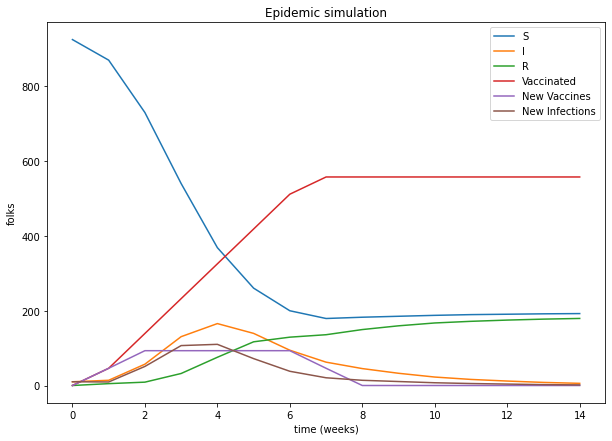

In [11]:
vacc = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60]
N = 934
k = 6
rg = RandomGraphGenerator(N,k)
status = np.zeros(N)
beta = 0.3
p = 0.7
simulation_time = 15 #weeks
attempts = 100
SIR = {'S':0,'I':1,'R':2}

init_infected = choice(rg.G.nodes,10, replace=False)
for inf in init_infected:
    status[inf] = 1
print(init_infected)
multiple_simulation(rg.G,SIR,status,simulation_time,beta,p,attempts,vacc)

In [14]:
from sklearn.model_selection import ParameterGrid
N = 934
vacc = [5,9,16,24,32,40,47,54,59,60,60,60,60,60,60,60]
status = np.zeros(N,dtype=np.int32)
init_infected = choice(range(status.shape[0]),1)
status[init_infected] = 1
simulation_time = 16
attempts = 10
SIR = {'S':0,'I':1,'R':2, 'V':3}
NI_true = [1,1,3,5,9,17,32,32,17,5,2,1,0,0,0,0]
k0, b0, p0 = 10, 0.3, 0.6
dk, db, dp = 1, 0.1, 0.1
paramatrix = np.array([[k0,b0,p0],[dk,db,dp]])

def RMSE(i,i_true):
    return np.sqrt(1/i.shape[0]*sum((i-i_true)**2))

def search_pandemic(tested_hp,N,model,params,i_true,state,duration,num,vaccination=None,best_res=None):
    grid = ParameterGrid(params) # creates a grid to perform gridsearch over the subset of parameters k,b,p
    best_res = best_res
    for params in grid:
        # check if the params have already been tested, if so skip the computation to spare time and computation
        if(params in tested_hp): 
            continue
        else:
            tested_hp.append(params)
        rg = RandomGraphGenerator(N,params['k']) #generate the graph with the new k
        ev_rate = multiple_simulation(rg.G,model,state,simulation_time,params['b'],params['p'],attempts,vacc,plot=False) #performs the simulation
        newly_inf = ev_rate[-1,:]
        result = RMSE(newly_inf,i_true) #compute RMSE
        if not best_res or result < best_res[0]: #check if it is the best result and in case it stores it
            best_res = [result,ev_rate,params]
        new = True
    return best_res, tested_hp

def plot_newly_infected(duration,i,i_true):
    ig, ax= plt.subplots(figsize=(10,7))
    ax.plot(duration, i, label='New Infected (Simulation)')
    ax.plot(duration, i_true, label='New Infected (GT)')
    ax.set(xlabel='time (weeks)',ylabel='folks', title='hp comparison (k,p,b)')
    ax.legend(loc='best');
    
        
def parameters_search(N,paramatrix,model,i_true,state,duration,num,vaccination=None):
    tested_hp = [] # every possible result computed
    best_res = None
    while True:
        params = validate_params(paramatrix) #checks params, lower bound, upper bount, dtype
        print(params) #print the params that are going to be tested
        # search the pandemic parameters over the subset, grid search + average of 10x simulations for each set
        sc_stat_par,tested_hp = search_pandemic(tested_hp,N,SIR,params,NI_true,status,simulation_time,attempts,vacc,best_res)
        if not best_res or sc_stat_par[0] < best_res[0]: #if new or it achieved a better score
            paramatrix[0,:] = sc_stat_par[2]['k'],sc_stat_par[2]['b'],sc_stat_par[2]['p'] #change the k0,p0,b0 center parameters
            best_res = sc_stat_par 
        elif sc_stat_par[2] == best_res[2] and paramatrix[1,1] >= 0.05: 
            #if equals reduce the step dp,db (dk is already minimum) down to 0.025 then it stops so it does not cycle unendly
            paramatrix[1,1:] /= 2
        elif sc_stat_par[0] >= best_res[0]: # stops the search
            break
            
    plot_avg_state(best_res[1],range(duration),vaccination)
    plot_newly_infected(range(duration),best_res[1][-1,:],i_true)
    print(best_res[0],best_res[2])
    
def validate_param(vals,lb=0,ub=1,integ=False):
    valval = []
    for v in vals:
        if v < lb: #lower bound
            v = lb
        elif v > ub: #upper bound
            v = ub
        if integ: #dtype
            v = int(v)
        else: #round the result to avoid ugly params as 0.999999999999999
            v = np.round(v, 3)
        valval.append(v)
    return valval
    
def validate_params(paramatrix): #construct the validated params dictionary 
    k0, b0, p0 = paramatrix[0,:]
    dk, db, dp = paramatrix[1,:]
    params = {
        'k': validate_param([k0-dk, k0, k0+dk],2,934,True),
        'b': validate_param([b0-db, b0, b0+db]),
        'p': validate_param([p0-dp, p0, p0+dp])
    }
    return params
    
            


{'k': [9, 10, 11], 'b': [0.2, 0.3, 0.4], 'p': [0.5, 0.6, 0.7]}
{'k': [8, 9, 10], 'b': [0.1, 0.2, 0.3], 'p': [0.5, 0.6, 0.7]}
{'k': [9, 10, 11], 'b': [0.0, 0.1, 0.2], 'p': [0.5, 0.6, 0.7]}
{'k': [9, 10, 11], 'b': [0.05, 0.1, 0.15], 'p': [0.55, 0.6, 0.65]}
{'k': [9, 10, 11], 'b': [0.075, 0.1, 0.125], 'p': [0.575, 0.6, 0.625]}
5.0078064060025325 {'b': 0.1, 'k': 10, 'p': 0.6}


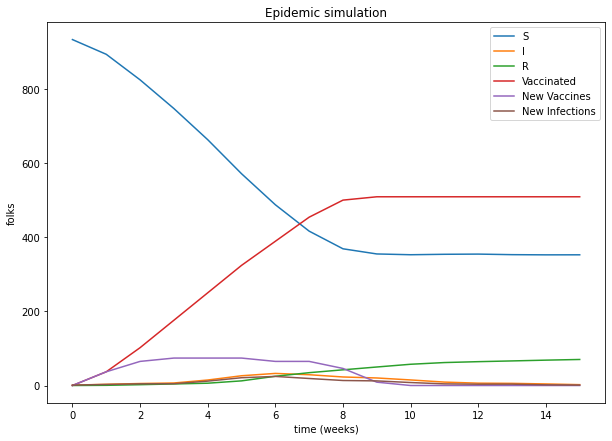

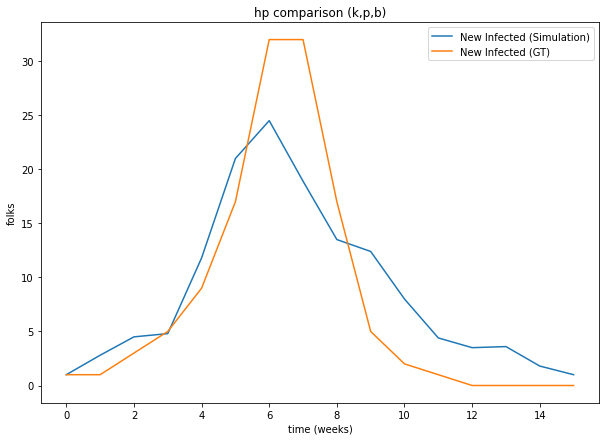

In [15]:
parameters_search(N,paramatrix,SIR,NI_true,status,simulation_time,attempts,vacc)

2.8613807855648994 {'b': 0.19999999999999998, 'k': 11, 'p': 0.5}